## Visualize results NARMAX experiments

In [1]:
using Revise
using JLD
using MAT
using Statistics
using StatsPlots
using LaTeXStrings
using Plots
pyplot();

In [2]:
include("visualization.jl");

In [3]:
alpha = 0.1
linewidth = 2;
styles = [:solid, :dash, :dot, :dashdot];

### Load results

In [19]:
# sample_sizes = [500,1000,2000,4000]
sample_sizes = 2 .^collect(6:12)
which_sizes = 1:length(sample_sizes)
num_sizes = length(which_sizes)
sample_sizes[which_sizes]'

1×7 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 64  128  256  512  1024  2048  4096

In [5]:
# Number of repetitions
num_repeats = 100

deg = 3
order = 4

results_sim_FEM = zeros(num_sizes,2)
results_prd_FEM = zeros(num_sizes,2)
results_sim_RLS = zeros(num_sizes,2)
results_prd_RLS = zeros(num_sizes,2)
results_sim_ILS = zeros(num_sizes,2)
results_prd_ILS = zeros(num_sizes,2)
avg_FE = zeros(num_sizes,2)
fin_FE = zeros(num_sizes,2)

RMS_sim_FEM = zeros(num_repeats,num_sizes)
RMS_prd_FEM = zeros(num_repeats,num_sizes)
RMS_sim_RLS = zeros(num_repeats,num_sizes)
RMS_prd_RLS = zeros(num_repeats,num_sizes)
RMS_sim_ILS = zeros(num_repeats,num_sizes)
RMS_prd_ILS = zeros(num_repeats,num_sizes)
avg_FE_r = zeros(num_repeats,num_sizes)
fin_FE_r = zeros(num_repeats,num_sizes)

for r = 1:num_repeats

    # Load
    FEM_data = load("results/results-NARMAX_FEM_M"*string(order)*"_degree"*string(deg)*"_r"*string(r)*".jld")
    RMS_prd_FEM[r,:] = FEM_data["RMS_prd"][which_sizes]
    RMS_sim_FEM[r,:] = FEM_data["RMS_sim"][which_sizes]
    avg_FE_r[r,:] = FEM_data["avg_FE"][which_sizes]
    fin_FE_r[r,:] = FEM_data["fin_FE"][which_sizes]

    RLS_data = load("results/results-NARMAX_RLS_M"*string(order)*"_degree"*string(deg)*"_r"*string(r)*".jld")
    RMS_prd_RLS[r,:] = RLS_data["RMS_prd"][which_sizes]
    RMS_sim_RLS[r,:] = RLS_data["RMS_sim"][which_sizes]

    ILS_data = matread("results/results-NARMAX_ILS_M"*string(order)*"_degree"*string(deg)*"_r"*string(r)*".mat")
    RMS_prd_ILS[r,:] = ILS_data["RMS_prd"][which_sizes]
    RMS_sim_ILS[r,:] = ILS_data["RMS_sim"][which_sizes]

end    

# Map all infinities to NaN
RMS_prd_FEM[isinf.(RMS_prd_FEM)] .= NaN
RMS_sim_FEM[isinf.(RMS_sim_FEM)] .= NaN
RMS_prd_RLS[isinf.(RMS_prd_RLS)] .= NaN
RMS_sim_RLS[isinf.(RMS_sim_RLS)] .= NaN
RMS_prd_ILS[isinf.(RMS_prd_ILS)] .= NaN
RMS_sim_ILS[isinf.(RMS_sim_ILS)] .= NaN
    
# Check for proportion of instable
instab_sim_FEM = mean(isnan.(RMS_sim_FEM),dims=1)
instab_prd_FEM = mean(isnan.(RMS_prd_FEM),dims=1)
instab_sim_RLS = mean(isnan.(RMS_sim_RLS),dims=1)
instab_prd_RLS = mean(isnan.(RMS_prd_RLS),dims=1)
instab_sim_ILS = mean(isnan.(RMS_sim_ILS),dims=1)
instab_prd_ILS = mean(isnan.(RMS_prd_ILS),dims=1)

# Populate RMS array
trim_prctile = 0.10
for n = 1:num_sizes
    results_sim_FEM[n,1] = tmean(filter(!isnan, RMS_sim_FEM[:,n]), tr=trim_prctile)
    results_sim_FEM[n,2] = trimse(filter(!isnan, RMS_sim_FEM[:,n]), tr=trim_prctile)
    results_prd_FEM[n,1] = tmean(filter(!isnan, RMS_prd_FEM[:,n]), tr=trim_prctile)
    results_prd_FEM[n,2] = trimse(filter(!isnan, RMS_prd_FEM[:,n]), tr=trim_prctile)

    results_sim_RLS[n,1] = tmean(filter(!isnan, RMS_sim_RLS[:,n]), tr=trim_prctile)
    results_sim_RLS[n,2] = trimse(filter(!isnan, RMS_sim_RLS[:,n]), tr=trim_prctile)
    results_prd_RLS[n,1] = tmean(filter(!isnan, RMS_prd_RLS[:,n]), tr=trim_prctile)
    results_prd_RLS[n,2] = trimse(filter(!isnan, RMS_prd_RLS[:,n]), tr=trim_prctile)

    results_sim_ILS[n,1] = tmean(filter(!isnan, RMS_sim_ILS[:,n]), tr=trim_prctile)
    results_sim_ILS[n,2] = trimse(filter(!isnan, RMS_sim_ILS[:,n]), tr=trim_prctile)
    results_prd_ILS[n,1] = tmean(filter(!isnan, RMS_prd_ILS[:,n]), tr=trim_prctile)
    results_prd_ILS[n,2] = trimse(filter(!isnan, RMS_prd_ILS[:,n]), tr=trim_prctile)
    
    avg_FE[n,1] = tmean(filter(!isnan, avg_FE_r[:,n]), tr=trim_prctile)
    avg_FE[n,2] = trimse(filter(!isnan, avg_FE_r[:,n]), tr=trim_prctile)
    fin_FE[n,1] = tmean(filter(!isnan, fin_FE_r[:,n]), tr=trim_prctile)
    fin_FE[n,2] = trimse(filter(!isnan, fin_FE_r[:,n]), tr=trim_prctile)
end

### Plot simulation error experiment

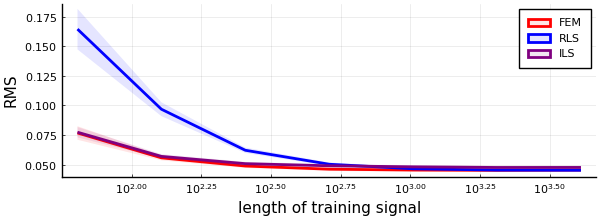

In [7]:
p6 = plot(sample_sizes[which_sizes], results_sim_FEM[:,1], 
          ribbon=[results_sim_FEM[:,2] results_sim_FEM[:,2]], 
          color="red", 
          label="FEM", 
          xscale=:log10,
#           yscale=:log10,
#           ylims=[0.08, 0.15],
          linewidth=linewidth,
          fillalpha=alpha,
#           title="Simulation error",
          xlabel="length of training signal",
          ylabel="RMS",
          size=(600,220))
plot!(sample_sizes[which_sizes], results_sim_RLS[:,1], 
     ribbon=[results_sim_RLS[:,2] results_sim_RLS[:,2]], 
     color="blue", 
     linewidth=linewidth,
     fillalpha=alpha,
     label="RLS")
plot!(sample_sizes[which_sizes], results_sim_ILS[:,1], 
     ribbon=[results_sim_ILS[:,2] results_sim_ILS[:,2]], 
     color="purple", 
     linewidth=linewidth,
     fillalpha=alpha,
     label="ILS")

In [8]:
savefig(p6, "figures/NARMAX-RMS-sim_deg"*string(deg)*"_order"*string(order)*".png")

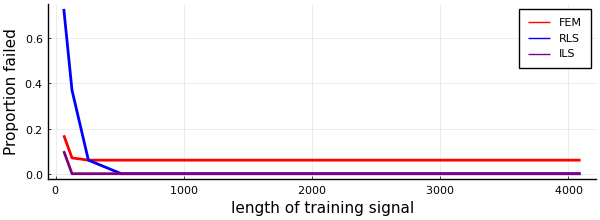

In [9]:
p111 = plot(sample_sizes[which_sizes], instab_sim_FEM', color="red", label="FEM", linewidth=2, ylabel="Proportion failed", xlabel="length of training signal", size=(600,220))
plot!(sample_sizes[which_sizes], instab_sim_RLS', color="blue", label="RLS", linewidth=2)#, ylims=[0., 1.])
plot!(sample_sizes[which_sizes], instab_sim_ILS', color="purple", label="ILS", linewidth=2)

In [10]:
savefig(p111, "figures/NARMAX-propfail-sim_deg"*string(deg)*"_order"*string(order)*".png")

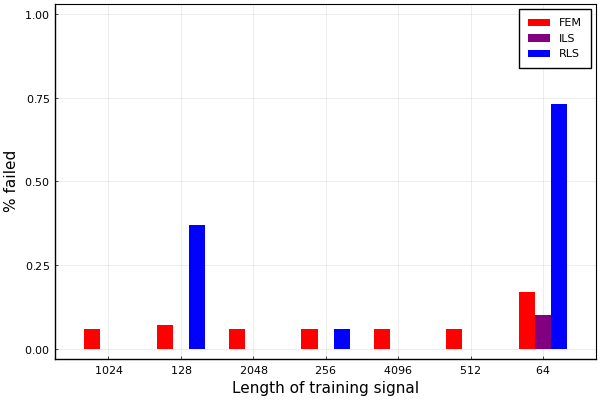

In [11]:
instab_sim = [instab_sim_FEM;
              instab_sim_RLS;
              instab_sim_ILS]

ctg = repeat(["FEM", "RLS", "ILS"], inner = num_sizes)
nam = repeat(string.(sample_sizes), outer=3)
colours = repeat(["red", "blue", "purple"], inner = num_sizes)

groupedbar(nam, instab_sim', group = ctg, color = colours, xlabel = "Length of training signal", ylabel = "% failed", bar_width = 0.67,
        lw = 0, framestyle = :box, ylims=[0., 1.], bar_position = :dodge)

### Plot 1-step ahead error experiments

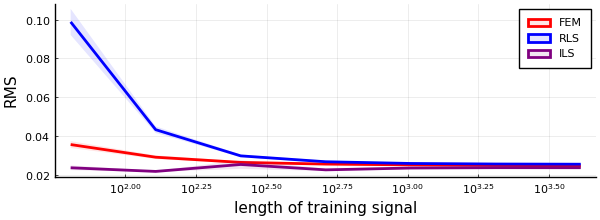

In [13]:
p7 = plot(sample_sizes[which_sizes], results_prd_FEM[:,1], 
          ribbon=[results_prd_FEM[:,2] results_prd_FEM[:,2]], 
          color="red", 
          label="FEM", 
          xscale=:log10,
#           yscale=:log10,
#           ylims=[0.10, 0.25],
          linewidth=linewidth,
          fillalpha=alpha,
          xlabel="length of training signal",
          ylabel="RMS",
          size=(600,220))
plot!(sample_sizes[which_sizes], results_prd_RLS[:,1], 
     ribbon=[results_prd_RLS[:,2] results_prd_RLS[:,2]], 
     color="blue", 
     linewidth=linewidth,
     fillalpha=alpha,
     label="RLS")
plot!(sample_sizes[which_sizes], results_prd_ILS[:,1], 
     ribbon=[results_prd_ILS[:,2] results_prd_ILS[:,2]], 
     color="purple", 
     linewidth=linewidth,
     fillalpha=alpha,
     label="ILS")

In [14]:
savefig(p7, "figures/NARMAX-RMS-prd_deg"*string(deg)*"_order"*string(order)*".png")

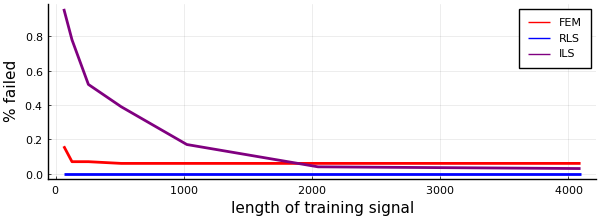

In [15]:
p121 = plot(sample_sizes[which_sizes], instab_prd_FEM', color="red", label="FEM", linewidth=2, ylabel="% failed", xlabel="length of training signal", size=(600,220))
plot!(sample_sizes[which_sizes], instab_prd_RLS', color="blue", label="RLS", linewidth=2)#, ylims=[0., 1.])
plot!(sample_sizes[which_sizes], instab_prd_ILS', color="purple", label="ILS", linewidth=2)

In [16]:
savefig(p121, "figures/NARMAX-propfail-prd_deg"*string(deg)*"_order"*string(order)*".png")

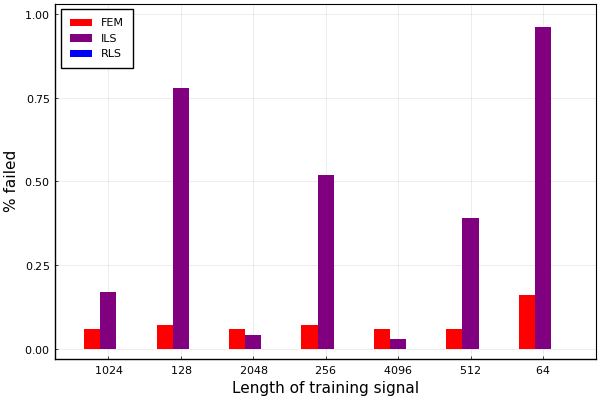

In [17]:
instab_prd = [instab_prd_FEM;
              instab_prd_RLS;
              instab_prd_ILS]

ctg = repeat(["FEM", "RLS", "ILS"], inner = num_sizes)
nam = repeat(string.(sample_sizes), outer=3)
colours = repeat(["red", "blue", "purple"], inner = num_sizes)

groupedbar(nam, instab_prd', group = ctg, color = colours, xlabel = "Length of training signal", ylabel = "% failed", bar_width = 0.67,
        lw = 0, framestyle = :box, ylims=[0., 1.], bar_position = :dodge)